# S-wave scattering phase shifts for an attractive square-well potential

In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
matplotlib.rcParams['figure.dpi'] = 130
# divide by zero? no wukkas
np.seterr(divide='ignore', invalid='ignore')
mu = 1
R = 1
R_max = 10
r = np.linspace(0, R_max, 1024)
k = np.linspace(0, 5, 1024)

def square_well(r, V_0):
    # define Square well potential with adjustable depth V_0
    V_sw = - V_0 * np.heaviside(R-r, 0)
    return V_sw
    
def E_k(k):
    # kinetic energy considering units of hbar=1
    E = k**2 / (2 * mu)
    return E

def phase_0(k, V_0):
    # first order approx to phase shift
    arg = np.sqrt(E_k(k) / (E_k(k) + V_0)) * np.tan(R * np.sqrt(2 * mu * (E_k(k) + V_0)))
    delta_0 = np.arctan(arg) - R * np.sqrt(2 * mu * E_k(k))
    return delta_0

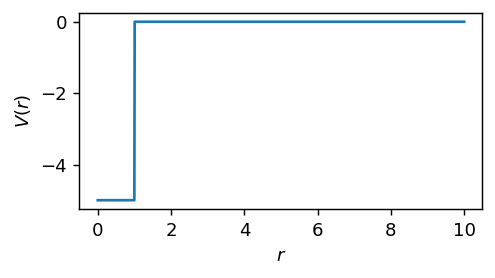

In [3]:
# square-well potential
plt.figure(figsize=(4,2))
plt.plot(r, square_well(r, 5))
plt.ylabel(r'$V(r)$')
plt.xlabel(r'$r$')
plt.show()

In [4]:
# little test to see that the function evaluates numerically
phase_0(5, 0.5)

-6.177269080098745

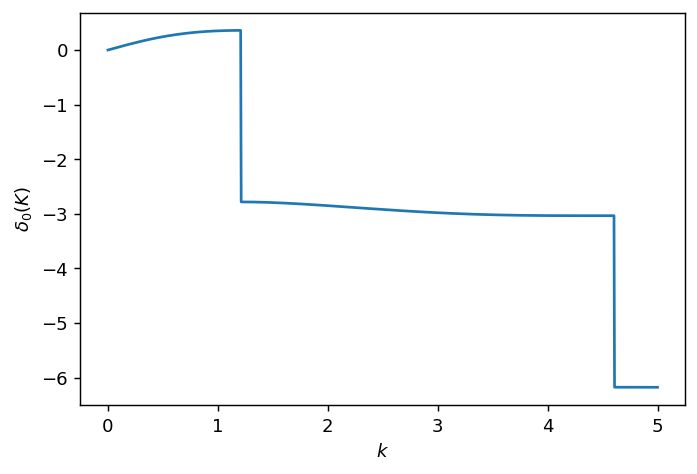

In [5]:
plt.plot(k, phase_0(k, 0.5))
plt.ylabel(r'$\delta_{0}(K)$')
plt.xlabel(r'$k$')
plt.show()
#so step why (?)

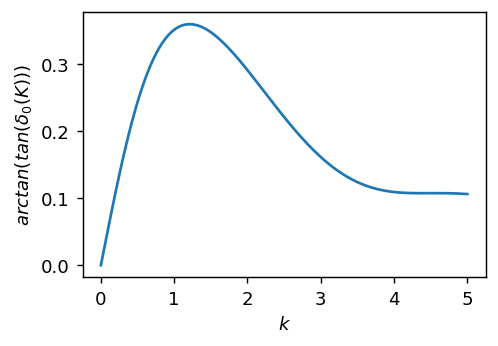

In [6]:
# a phase shift "stepyness" FIX
plt.figure(figsize=(4,2.7))
plt.plot(k, np.arctan(np.tan(phase_0(k, 0.5))))
plt.ylabel(r'$arctan(tan(\delta_{0}(K)))$',size=10)
plt.xlabel(r'$k$',size=10)
plt.show()

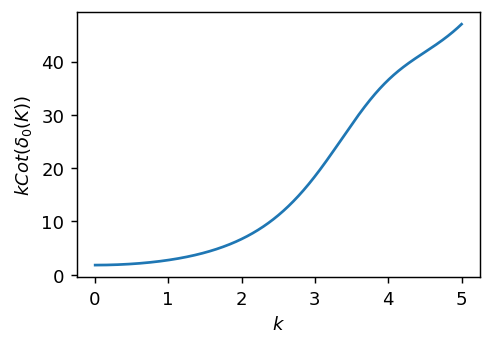

In [7]:
# another phase shift "stepyness" FIX
# k Cot(\delta_0(k))
plt.figure(figsize=(4,2.7))
plt.plot(k, k / np.tan(phase_0(k, 0.5)))
plt.ylabel(r'$ k Cot(\delta_{0}(K))$',size=10)
plt.xlabel(r'$k$',size=10)
plt.show()
#blowsup?! maybe that's not great (?)

### Variable Phase Approach

nonlinear ODE used in VPA: 
$\delta_\rho'(r) = -\frac{2 \mu sin^{2}(\delta_\rho +k r)}{k}$ with IC: $\delta_\rho = 0$

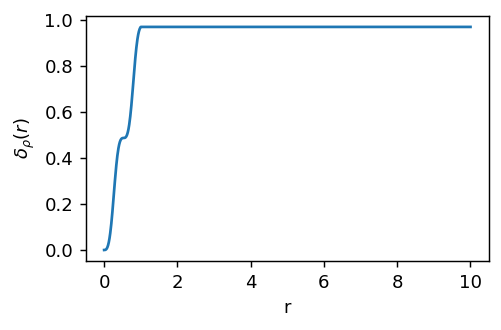

In [8]:
def ODE(delta_rho, r, k, V_0):
    top = 2 * mu * square_well(r, V_0) * np.sin(k * r + delta_rho)**2
    ddeltarho_dr = -(top/k)
    return ddeltarho_dr
                                 
# solve ODE from VPA
delta_rho = odeint(ODE, 0, r, args=(5, 5))
# print(delta_rho)

# plot results
plt.figure(figsize=(4,2.5))
plt.plot(r,delta_rho)
plt.xlabel('r')
plt.ylabel(r'$\delta_\rho(r)$')
plt.show()

#### WHY DOES MINE HAVE A KINK?
#### Do I need to stablish the value $R_{max}$ for integration?

#### Do a quick check against the analytic result with sample values for k and V0 to see the accuracy we are getting 

#### Check the cutoff phase shift out to $R_{max}$.  Does this plot make sense?

Now that it seems to be working, try plots of the $ k Cot(\delta_0(k))$ and $\delta_{?}$ for a different depth.
#### How do you explain the results in terms of Levinson's theorem?

# Trying out different well depths 
(Based on scatteringprimer.pdf ch.2).

$\ell = 0$ phase shift $\delta_0$ (in radians) for square well with 
$ m = \hbar = R = 1$ 

For $V_0$, versus energy $E = \frac{\hbar^2 k^2}{2m}$.
where $V_0 = [0.25, 0.5, 1.0, 1.5]$

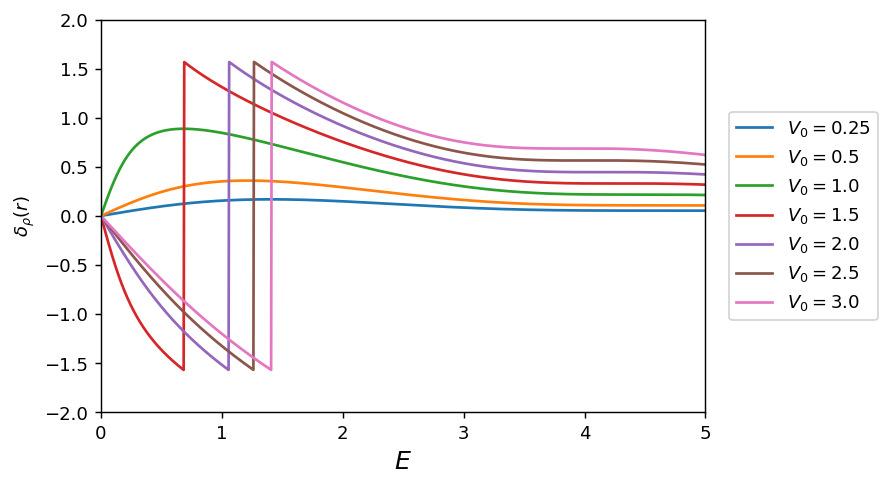

In [9]:
# analytic phase shift using arctan(tan((\delta_0(k))))
v_0 = [0.25, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
for i in v_0:
    linei, = plt.plot(k, np.arctan(np.tan(phase_0(k, i))), label=f"$V_0 = {i}$")
    plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))

plt.ylim(-2, 2)
plt.xlim(0, 5)
plt.ylabel(r'$\delta_\rho(r)$')
plt.xlabel(r'$E$',size=14)
plt.show()

Notice that $V_0$ increases, a bound state appears.
The apparent discontinuity in the phase shift for V 0 = 1.5 is really just an ambiguity in angle: here $\delta$ is restricted to be between $−\pi$ and $+\pi$ radians.
Because of this ambiguity, it is sometimes convenient to plot 
$k cot(\delta_0)$

#### As one goes from V 0 = 1 to V 0 = 1.5,  the phase shift become negative.

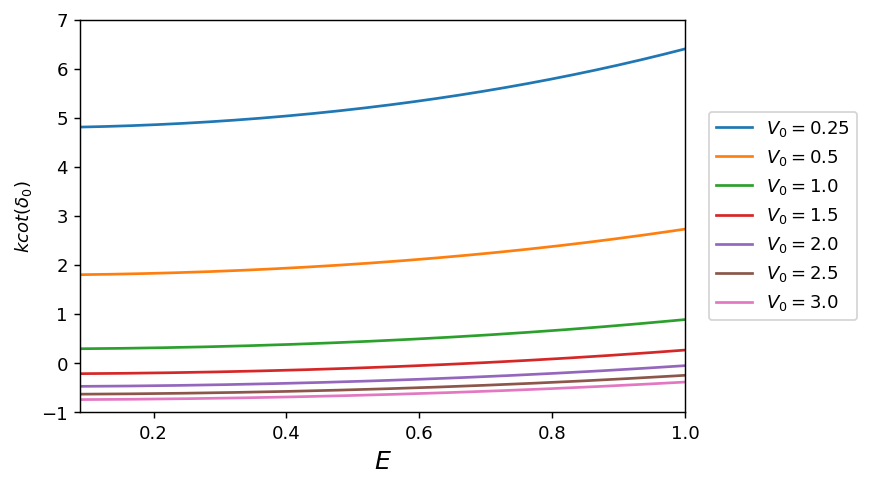

In [10]:
# analytic phase shift using k cot(phase_0(k, v_0))
for j in v_0:
    linej, = plt.plot(k, k / np.tan(phase_0(k, j)), label=f"$V_0 = {j}$")
    plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))

plt.ylim(-1, 7)
plt.xlim(0.09, 1)
plt.ylabel(r'$kcot(\delta_0)$')
plt.xlabel(r'$E$',size=14)
plt.show()

#### why does $k cot(\delta_0)$ blow up?

we can interpret the y-intercept and slope
of $k cot(\delta_0)$ in terms of fundamental quantities called the scattering length and effective range. Again, as the y-intercept passes through zero, we see that this corresponds to a bound state.

I DON'T SEE THIS, but paper says: (((At the same time one sees the y-intercept pass through zero from positive to negative. Later, when we discuss Levinson’s theorem, we will see both of these are associated with a new bound state appearing as $V_0$ is increased))


#### does the y-intercept of $k cot(\delta_0)$ become positive again?

#### why are bound states closer the deeper the well is?